In [19]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from hyperplane_LSH import hyperplane_LSH
from hyperplane_LSH import plot_svc_decision_function
from nltk import ngrams
import sys

### Lets see how random hyperplanes look with my(Sharwin Bobde) module
we will make 10 random hyperplanes for normal data.
we will aslso have random points from 0-20

In [20]:
# dummy data for 2d plot
X = np.random.uniform(0,20, 100).reshape((50,2))

In [21]:
hyp_LSH = hyperplane_LSH(X, 10)

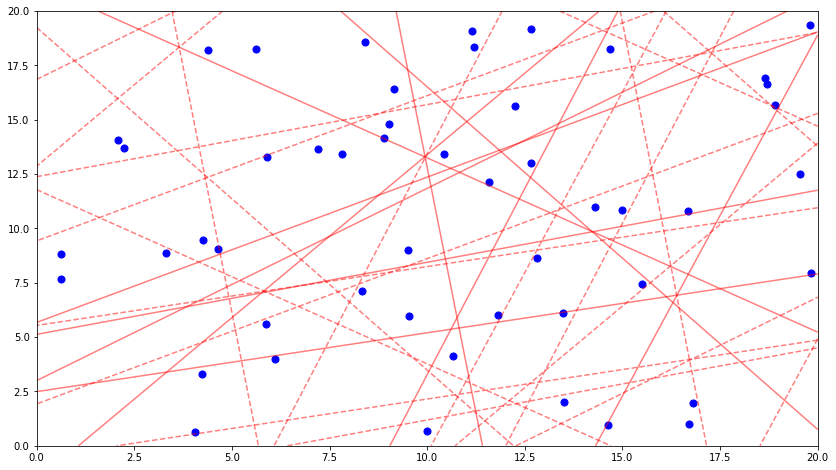

In [22]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches((14,8))
ax.set_xlim((0,20))
ax.set_ylim((0,20))
ax.scatter(X[:, 0], X[:, 1], c='blue', s=50, cmap='autumn')
for h in hyp_LSH.H:
    plot_svc_decision_function(h, ax, plot_support=False)


The above figure shows dummy data points for a 2D problem with the required random hyperplanes (SVC in this implimentation) and their margins. Notice the scaling is proper and every run/initialisation generates randomly inistialised hyperplanes.

### Lets get to the task
- we will first devide the discretised data according to the requirement, grouped by source-destination IP adresses.
- find all possible ngrams for making a blueprint for the signature
- find n-gram counts for a particular IP pair and fill in the counts in the template

In [23]:
from hyperplane_LSH import generate_signature

# import discretised features
df = pd.read_csv("data/TotBytes_Dur_discretized.csv")

groupby_cols = ['SrcAddr', 'DstAddr' ] 
groupby_cols = df[groupby_cols].to_numpy()
groupby_cols_unique = np.unique(groupby_cols, axis=0)

n_grams_IP = []
n_grams_sigs = []
# know all possible signatures
unique_ngrams = np.unique(np.array(list(ngrams(df['TotBytes_Dur'].to_numpy(), 3))), axis=0)
# print(unique_ngrams.shape)

# get signatures (counts of ngrams)
for group in groupby_cols_unique:
    is_in_group =  np.logical_and( groupby_cols[:,0] == group[0], groupby_cols[:,1] == group[1])
    indexes = np.where(is_in_group)
    items = df['TotBytes_Dur'].to_numpy()[indexes]
    temp_grams = list(ngrams(items, 3))

    if np.shape(temp_grams)[0] == 0: # has < 3 entries therefore no 3-grams.... lets not consider these
        continue

    n_grams_IP.append(group)
    # TODO; generate signature
    signature = generate_signature(temp_grams, unique_ngrams)
    n_grams_sigs.append(signature)

n_grams_IP = np.array(n_grams_IP)
n_grams_sigs = np.array(n_grams_sigs)

ngram_Y = np.arange(n_grams_IP.shape[0])

print(ngram_Y.shape)
print(n_grams_sigs.shape)

(303,)
(303, 132)


We have stored the 3-grams in `n_grams` and the corresponfing IP source-destination pair in `n_grams_IP` 

### Brute force time for NN search for n-gram signatures

In [24]:


# build brute force nn search.. we will use kNN to check the performance
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='brute', n_jobs=1)
nbrs.fit(n_grams_sigs)

from time import time
times_nn = []
for sig in n_grams_sigs:
    start = time()
    nbrs.kneighbors([sig])# find index of closest neighbour (not itself)
    end = time()
    times_nn.append(end-start)

times_nn_mean = np.mean(times_nn)
times_nn_std = np.std(times_nn)

print("mean time: " + str(times_nn_mean))
print("std time: " + str(times_nn_std))

mean time: 0.0011397659188449973
std time: 0.0033097323550464936


### Brute force time for NN search for hyperplane-LSH hashed n-gram signatures

In [25]:
# hash into buckets
n = 30
LSH = hyperplane_LSH(X=n_grams_sigs, n=n)
n_grams_sigs_hashed = LSH.hash()
print("hashed signatures")
np.set_printoptions(threshold=sys.maxsize)
print(n_grams_sigs_hashed)
print(n_grams_sigs_hashed.shape)

from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='brute', n_jobs=1)
nbrs.fit(n_grams_sigs_hashed)

from time import time
times_hashed = []
for sig in n_grams_sigs_hashed:
    start = time()
    nbrs.kneighbors([sig])# find index of closest neighbour (not itself)
    end = time()
    times_hashed.append(end-start)

times_hashed_mean = np.mean(times_hashed)
times_hashed_std = np.std(times_hashed)

print("mean time (for n=10) : " + str(times_hashed_mean))
print("std time  (for n=10) : " + str(times_hashed_std))

hashed signatures
[[1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0

In the above output we can clearly observe IP source-dest pairs which show anomalous activity n-gram signature that is hashed differently than other data :)

### Analysis for changing n (no. of hyperplanes)

In [26]:
from tqdm import tqdm

N = [3, 5, 10, 15, 20, 30, 35, 40, 50, 60]

means_ = []
stds_ = []
for n in tqdm(N):
    LSH = hyperplane_LSH(X=n_grams_sigs, n=n)
    n_grams_sigs_hashed = LSH.hash()

    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='brute', n_jobs=1)
    nbrs.fit(n_grams_sigs_hashed)

    from time import time
    times_hashed = []
    for sig in n_grams_sigs_hashed:
        start = time()
        nbrs.kneighbors([sig])# find index of closest neighbour (not itself)
        end = time()
        times_hashed.append(end-start)

    means_.append(np.mean(times_hashed))
    stds_.append(np.std(times_hashed))

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


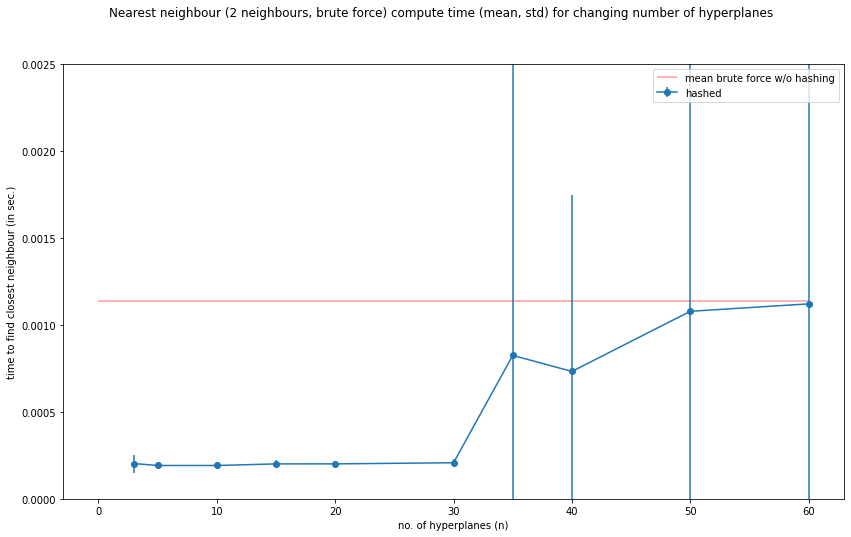

In [27]:
fig = plt.figure(figsize=(14,8))
fig.suptitle('Nearest neighbour (2 neighbours, brute force) compute time (mean, std) for changing number of hyperplanes')
plt.ylim((0,0.0025))
plt.hlines(y=[times_nn_mean, times_nn_mean - times_nn_std/2, times_nn_mean + times_nn_std/2], xmin=0, xmax=N[-1], colors='r', label='mean brute force w/o hashing', linestyles=['-', '--', '--'], alpha=0.4)
plt.errorbar(x=N, y=means_, yerr=stds_, fmt='o-', label='hashed')
plt.ylabel('time to find closest neighbour (in sec.)')
plt.xlabel('no. of hyperplanes (n)')
plt.legend()


We can see that the mean compute time for 3 to 30 hyperplanes is definately lower than the conterpart without hashing. Both the mean and std increase aster having more than 30 hyperplanes for this feature.

Keep in mind that we are using timing with small operatuons the standard deviation can be huge and change from system to system and for every run. because this is a hardware issue there can be no seed only averaging. I have provided only **mean and std** and not averaged results over 10 or 100 runs because this is not the purpose of this task. after many runs the same conclusion was found. 

### Explaination (timing changes on every run... See `Report` for definate answers)
as we hash signatures to smaller bins, we naturally see that the compute time decreases. The increased compute time and standard deviation from 35 to 60 hyperplanes could be because of machine specific issues (caching). It is interesting however to see the sudden increase in compute time 